<a href="https://colab.research.google.com/github/nah90/CS767_GenerativeAdversarialNN/blob/main/CS767_hw4_Horak.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

#Assignment 4- Deep Convolutional Generative Adversarial Network (DCGAN)

In [ ]:
#INTENT: Packages for NNs and to generate GIFs
import tensorflow as tf

#Remove # to install
#!pip install imageio
#!pip install git+https://github.com/tensorflow/docs

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import tensorflow_docs.vis.embed as embed
import time

from IPython import display

In [ ]:
#INTENT: To load and prepare the dataset for training the generator and discriminator

(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data() #Import training image/label data

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32') #Reshape to 28, 28, 1
train_images = (train_images - 127.5) / 127.5  #Normalize the images to [-1, 1]

BUFFER_SIZE = 60000 #Set constant BUFFER_SIZE
BATCH_SIZE = 256 #Set constant BATCH_SIZE

#Slice (horizontally), batch, and shuffle the training data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE) #Create random dataset from tensor slices
#With BUFFER_SIZE and BATCH_SIZE

In [ ]:
#INTENT: Create the generator model

def make_generator_model(): #Function to make generator model
    model = tf.keras.Sequential() #Create model
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,))) #Add 7, 7, 256 dense layer with no bias
    model.add(layers.BatchNormalization()) #Add Batch Normalization
    model.add(layers.LeakyReLU()) #LeakyReLU activation method

    model.add(layers.Reshape((7, 7, 256))) #Reshape to match dense layer dimensions
    assert model.output_shape == (None, 7, 7, 256)  #Note: None is the batch size

    #Use upsampling layers to produce an image from seed (random noise)
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)) #Conv2DTranspose to 128, (5,5)
    #with padding and no bias
    assert model.output_shape == (None, 7, 7, 128) #Output as 7, 7, 128 dimension object
    model.add(layers.BatchNormalization()) #Add Batch Normalization
    model.add(layers.LeakyReLU()) #LeakyReLU activation method

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)) #Conv2DTranspose to 64, (5,5)
    #with (2,2) strides with padding and no bias
    assert model.output_shape == (None, 14, 14, 64) #Output as 14, 14, 64 dimension object
    model.add(layers.BatchNormalization()) #Add Batch Normalization
    model.add(layers.LeakyReLU()) #LeakyReLU activation method

    #Reach desired image size of 28x28x1
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')) #tanh activation
    #Conv2DTranspose to 1, (5,5) with (2,2) strides and padding and no bias
    assert model.output_shape == (None, 28, 28, 1) #Assert (None, 28, 28, 1) output

    return model #Return model

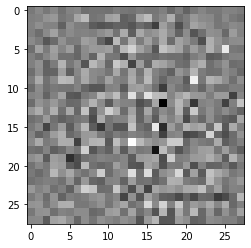

In [ ]:
#INTENT: Use the generator to create an image

generator = make_generator_model() #Make generator

noise = tf.random.normal([1, 100]) #Set noise variable
generated_image = generator(noise, training=False) #Generate image

plt.imshow(generated_image[0, :, :, 0], cmap='gray') #Show image

In [ ]:
#INTENT: Create the discriminator model

def make_discriminator_model(): #Function to make discriminator model
    model = tf.keras.Sequential() #Create model
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', #64, (5,5) Conv2D layer with (2,2) strides and padding
                                     input_shape=[28, 28, 1])) #Input shape (28, 28, 1)
    model.add(layers.LeakyReLU()) #LeakyReLU activation method
    model.add(layers.Dropout(0.30)) #Dropout layer randomly sets its input units to 0 at 30% rate

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')) #Conv2D 128, (5,5) dimension with (2,2) strides and padding
    model.add(layers.LeakyReLU()) #LeakyReLU activation method
    model.add(layers.Dropout(0.30)) #Dropout layer randomly sets its input units to 0 at 30% rate

    model.add(layers.Flatten()) #Flatten the Conv2D layer
    model.add(layers.Dense(1)) #Dense layer as output

    return model #Return model

In [ ]:
#INTENT: Use the discriminator to classify images as real/fake by training

discriminator = make_discriminator_model() #Make discriminator
decision = discriminator(generated_image) #Sample decision
print (decision) #Print decision

tf.Tensor([[0.00028779]], shape=(1, 1), dtype=float32)


In [ ]:
#INTENT: Define loss functions and optimizers for both models

#This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True) #Use BinaryCrossentropy

In [ ]:
#INTENT: Define discriminator loss- how discriminator predicts real vs fake

def discriminator_loss(real_output, fake_output): #Function for discriminator loss
    real_loss = cross_entropy(tf.ones_like(real_output), real_output) #Loss of real outputs
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output) #Loss of fake outputs
    total_loss = real_loss + fake_loss #Sum losses
    return total_loss #Return total losses

In [ ]:
#INTENT: Compare discriminator decisions to an array of 1s - how well generator able to trick discriminator

def generator_loss(fake_output): #Function for generatorloss
    return cross_entropy(tf.ones_like(fake_output), fake_output) #Return crossentropy accross fake outputs
    #If generator is performing well, the discriminator will classify its generated fake images as real (1)

#Generator and discriminator optimizers are different since each network is trained separately
generator_optimizer = tf.keras.optimizers.Adam(1e-4) #Generator optimizer with 'Adam' and very small learning rate
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4) #Discriminator optimizer with 'Adam' and very small learning rate

In [ ]:
#INTENT: Allow saving of checkpoints to save and restore models

checkpoint_dir = './training_checkpoints' #Create checkpoint directory
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt") #Prefix
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer, #Create checkpoint
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
#INTENT: Define the training loop

EPOCHS = 50 #Number of epochs to iterate through 
noise_dim = 100 #Dimensions of noise
num_examples_to_generate = 16 #Number of examples to generate

#You will reuse this seed over time (so it's easier)
#to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim]) #Set seed

In [ ]:
#INTENT: Produce images and classify real images- then gradients update generator/discriminator

#Notice the use of `tf.function`
#This annotation causes the function to be "compiled".
@tf.function
def train_step(images): #Function to train step
  
    noise = tf.random.normal([BATCH_SIZE, noise_dim]) #Create noise

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

      generated_images = generator(noise, training=True) #Create generated images

      real_output = discriminator(images, training=True) #Create real output
      fake_output = discriminator(generated_images, training=True) #Create fake output

      gen_loss = generator_loss(fake_output) #Generator loss
      disc_loss = discriminator_loss(real_output, fake_output) #Discriminator loss

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables) #Gradients of generator
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables) #Gradients of discriminator

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables)) #Update generator optimizer with gradients
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables)) #Update discriminator optimizer with gradients

In [ ]:
#INTENT: Define train function

def train(dataset, epochs): #Function to train on dataset
  for epoch in range(epochs): #For loop through epochs
    start = time.time()

    for image_batch in dataset: #For loop to train step on image batch
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True) #Clear display output
    generate_and_save_images(generator, #Generate and save images
                             epoch + 1,
                             seed)

    #Save the model every 15 epochs
    if (epoch + 1) % 15 == 0: 
      checkpoint.save(file_prefix = checkpoint_prefix) #Save checkpoint every 15 epochs

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  #Generate after the final epoch
  display.clear_output(wait=True) #Clear output
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [ ]:
#INTENT: Create and save images

def generate_and_save_images(model, epoch, test_input): #Function to generate and save images
  #Notice `training` is set to False.
  #This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4)) #Create display figure

  for i in range(predictions.shape[0]): #Plot shapes
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch)) #Save images
  plt.show() #Show plot

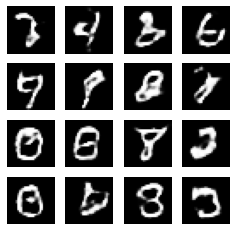

In [ ]:
#INTENT: Train the model

#Train generator and discriminator simultaneously
train(train_dataset, EPOCHS)

In [ ]:
#INTENT: Restore the latest checkpoint

checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir)) #Checkpoint restore

In [ ]:
#INTENT: Create a GIF

#Display a single image using the epoch number
def display_image(epoch_no): #Function to display image
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
#INTENT: Display image

display_image(EPOCHS)

FileNotFoundError: ignored

In [ ]:
#INTENT: Use imageio to create animated gif using images saved during training

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png') #Create filenames variable
  filenames = sorted(filenames) #Sort filenames
  for filename in filenames: #Loop through file names
    image = imageio.imread(filename) #Create image variable
    writer.append_data(image) #Append data as writer
  image = imageio.imread(filename) #Read image
  writer.append_data(image) #Append data as writer

NameError: ignored

In [ ]:
#INTENT: Embed gif

embed.embed_file(anim_file) #Embed gif

NameError: ignored

#First Code Modification

In [ ]:
#INTENT: New generator model with added dropout instances at 0.30 for first code modification

def make_generator_model1(): #Function to make generator model
    model = tf.keras.Sequential() #Create model
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,))) #Add 7, 7, 256 dense layer with no bias
    model.add(layers.BatchNormalization()) #Add Batch Normalization
    model.add(layers.LeakyReLU()) #LeakyReLU activation method
    model.add(layers.Dropout(0.30)) #Dropout layer randomly sets its input units to 0 at 30% rate

    model.add(layers.Reshape((7, 7, 256))) #Reshape to match dense layer dimensions
    assert model.output_shape == (None, 7, 7, 256)  #Note: None is the batch size

    #Use upsampling layers to produce an image from seed (random noise)
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)) #Conv2DTranspose to 128, (5,5)
    #with padding and no bias
    assert model.output_shape == (None, 7, 7, 128) #Output as 7, 7, 128 dimension object
    model.add(layers.BatchNormalization()) #Add Batch Normalization
    model.add(layers.LeakyReLU()) #LeakyReLU activation method
    model.add(layers.Dropout(0.30)) #Dropout layer randomly sets its input units to 0 at 30% rate

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)) #Conv2DTranspose to 64, (5,5)
    #with (2,2) strides with padding and no bias
    assert model.output_shape == (None, 14, 14, 64) #Output as 14, 14, 64 dimension object
    model.add(layers.BatchNormalization()) #Add Batch Normalization
    model.add(layers.LeakyReLU()) #LeakyReLU activation method
    model.add(layers.Dropout(0.30)) #Dropout layer randomly sets its input units to 0 at 30% rate

    #Reach desired image size of 28x28x1
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')) #tanh activation
    #Conv2DTranspose to 1, (5,5) with (2,2) strides and padding and no bias
    assert model.output_shape == (None, 28, 28, 1) #Assert (None, 28, 28, 1) output

    return model #Return model

In [ ]:
#INTENT: With first code modification, train new generator and discriminator objects and create image gif 

(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data() #Import training image/label data

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32') #Reshape to 28, 28, 1
train_images = (train_images - 127.5) / 127.5  #Normalize the images to [-1, 1]

BUFFER_SIZE = 60000 #Set constant BUFFER_SIZE
BATCH_SIZE = 256 #Set constant BATCH_SIZE

#Slice (horizontally), batch, and shuffle the training data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE) #Create random dataset from tensor slices
#With BUFFER_SIZE and BATCH_SIZE

generator = make_generator_model1() #Make generator

discriminator = make_discriminator_model() #Make discriminator

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True) #Use BinaryCrossentropy

#Generator and discriminator optimizers are different since each network is trained separately
generator_optimizer = tf.keras.optimizers.Adam(1e-4) #Generator optimizer with 'Adam' and very small learning rate
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4) #Discriminator optimizer with 'Adam' and very small learning rate

#Define the training loop
EPOCHS = 80 #Number of epochs to iterate through 
noise_dim = 100 #Dimensions of noise
num_examples_to_generate = 16 #Number of examples to generate

#Keep seed as is

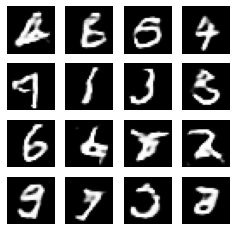

In [ ]:
#INTENT: Train the model

#Train generator and discriminator simultaneously
train(train_dataset, EPOCHS)

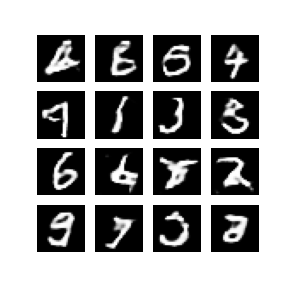

In [ ]:
#INTENT: Display image

display_image(EPOCHS)

In [ ]:
#INTENT: Use imageio to create animated gif using images saved during training
anim_file1 = 'dcgan1.gif'

with imageio.get_writer(anim_file1, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
#INTENT: Embed gif
embed.embed_file(anim_file1)

NameError: ignored

#Second Code Modification



In [ ]:
#INTENT: Create the second code modification discriminator model with Batch Normalization
#And an additional Conv2D layer

def make_discriminator_model2(): #Function to make discriminator model
    model = tf.keras.Sequential() #Create model
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', #64, (5,5) Conv2D layer with (2,2) strides and padding
                                     input_shape=[28, 28, 1])) #Input shape (28, 28, 1)
    model.add(layers.BatchNormalization()) #Add Batch Normalization                                 
    model.add(layers.LeakyReLU()) #LeakyReLU activation method
    model.add(layers.Dropout(0.30)) #Dropout layer randomly sets its input units to 0 at 30% rate

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')) #Conv2D 128, (5,5) dimension with (2,2) strides and padding
    model.add(layers.BatchNormalization()) #Add Batch Normalization
    model.add(layers.LeakyReLU()) #LeakyReLU activation method
    model.add(layers.Dropout(0.30)) #Dropout layer randomly sets its input units to 0 at 30% rate

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same')) #Conv2D 256, (5,5) dimension with (2,2) strides and padding
    model.add(layers.BatchNormalization()) #Add Batch Normalization
    model.add(layers.LeakyReLU()) #LeakyReLU activation method
    model.add(layers.Dropout(0.30)) #Dropout layer randomly sets its input units to 0 at 30% rate

    model.add(layers.Flatten()) #Flatten the Conv2D layer
    model.add(layers.Dense(1)) #Dense layer as output

    return model #Return model

In [ ]:
#INTENT: With second code modification, train new generator and discriminator objects and create image gif 

(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data() #Import training image/label data

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32') #Reshape to 28, 28, 1
train_images = (train_images - 127.5) / 127.5  #Normalize the images to [-1, 1]

BUFFER_SIZE = 60000 #Set constant BUFFER_SIZE
BATCH_SIZE = 256 #Set constant BATCH_SIZE

#Slice (horizontally), batch, and shuffle the training data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE) #Create random dataset from tensor slices
#With BUFFER_SIZE and BATCH_SIZE

generator = make_generator_model1() #Make generator

discriminator = make_discriminator_model2() #Make discriminator

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True) #Use BinaryCrossentropy

#Generator and discriminator optimizers are different since each network is trained separately
generator_optimizer = tf.keras.optimizers.Adam(1e-4) #Generator optimizer with 'Adam' and very small learning rate
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4) #Discriminator optimizer with 'Adam' and very small learning rate

#Define the training loop
EPOCHS = 80 #Number of epochs to iterate through 
noise_dim = 100 #Dimensions of noise
num_examples_to_generate = 16 #Number of examples to generate

#Keep seed as is

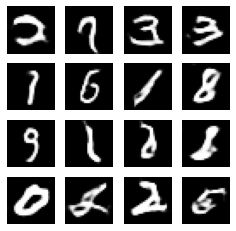

In [ ]:
#INTENT: Train the model

#Train generator and discriminator simultaneously
train(train_dataset, EPOCHS)

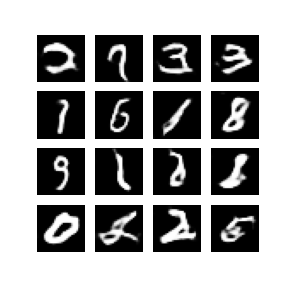

In [ ]:
#INTENT: Display image

display_image(EPOCHS)

In [ ]:
#INTENT: Use imageio to create animated gif using images saved during training
anim_file2 = 'dcgan2.gif'

with imageio.get_writer(anim_file2, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


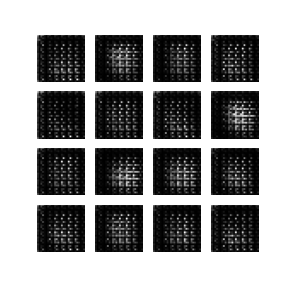

In [ ]:
#INTENT: Embed gif
embed.embed_file(anim_file2)

#Third Code Modification

In [ ]:
#INTENT: Create the third code modification generator model with additional Conv2DTranspose layer

def make_generator_model3(): #Function to make generator model
    model = tf.keras.Sequential() #Create model
    model.add(layers.Dense(7*7*512, use_bias=False, input_shape=(100,))) #Add 7, 7, 512 dense layer with no bias
    model.add(layers.BatchNormalization()) #Add Batch Normalization
    model.add(layers.LeakyReLU()) #LeakyReLU activation method
    model.add(layers.Dropout(0.30)) #Dropout layer randomly sets its input units to 0 at 30% rate

    model.add(layers.Reshape((7, 7, 512))) #Reshape to match dense layer dimensions
    assert model.output_shape == (None, 7, 7, 512)  #Note: None is the batch size

    #Use upsampling layers to produce an image from seed (random noise)
    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False)) #Conv2DTranspose to 256, (5,5)
    #with padding and no bias
    assert model.output_shape == (None, 7, 7, 256) #Output as 7, 7, 256 dimension object
    model.add(layers.BatchNormalization()) #Add Batch Normalization
    model.add(layers.LeakyReLU()) #LeakyReLU activation method
    model.add(layers.Dropout(0.30)) #Dropout layer randomly sets its input units to 0 at 30% rate

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)) #Conv2DTranspose to 128, (5,5)
    #with padding and no bias
    assert model.output_shape == (None, 7, 7, 128) #Output as 7, 7, 128 dimension object
    model.add(layers.BatchNormalization()) #Add Batch Normalization
    model.add(layers.LeakyReLU()) #LeakyReLU activation method
    model.add(layers.Dropout(0.30)) #Dropout layer randomly sets its input units to 0 at 30% rate

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)) #Conv2DTranspose to 64, (5,5)
    #with (2,2) strides with padding and no bias
    assert model.output_shape == (None, 14, 14, 64) #Output as 14, 14, 64 dimension object
    model.add(layers.BatchNormalization()) #Add Batch Normalization
    model.add(layers.LeakyReLU()) #LeakyReLU activation method
    model.add(layers.Dropout(0.30)) #Dropout layer randomly sets its input units to 0 at 30% rate

    #Reach desired image size of 28x28x1
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')) #tanh activation
    #Conv2DTranspose to 1, (5,5) with (2,2) strides and padding and no bias
    assert model.output_shape == (None, 28, 28, 1) #Assert (None, 28, 28, 1) output

    return model #Return model

In [ ]:
#INTENT: With third code modification, train new generator and discriminator objects and create image gif 

(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data() #Import training image/label data

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32') #Reshape to 28, 28, 1
train_images = (train_images - 127.5) / 127.5  #Normalize the images to [-1, 1]

BUFFER_SIZE = 60000 #Set constant BUFFER_SIZE
BATCH_SIZE = 64 #Set constant BATCH_SIZE at 64 from 256

#Slice (horizontally), batch, and shuffle the training data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE) #Create random dataset from tensor slices
#With BUFFER_SIZE and BATCH_SIZE

generator = make_generator_model3() #Make generator

discriminator = make_discriminator_model2() #Make discriminator

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True) #Use BinaryCrossentropy

#Generator and discriminator optimizers are different since each network is trained separately
generator_optimizer = tf.keras.optimizers.Adam(1e-4) #Generator optimizer with 'Adam' and very small learning rate
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4) #Discriminator optimizer with 'Adam' and very small learning rate

#Define the training loop
EPOCHS = 50 #Number of epochs to iterate through 
noise_dim = 100 #Dimensions of noise
num_examples_to_generate = 16 #Number of examples to generate

#Keep seed as is

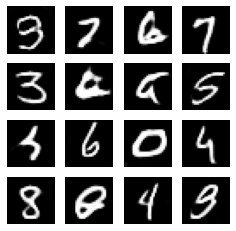

In [ ]:
#INTENT: Train the model

#Train generator and discriminator simultaneously
train(train_dataset, EPOCHS)

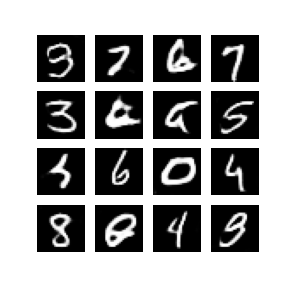

In [ ]:
#INTENT: Display image

display_image(EPOCHS)

In [ ]:
#INTENT: Use imageio to create animated gif using images saved during training
anim_file3 = 'dcgan3.gif'

with imageio.get_writer(anim_file3, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


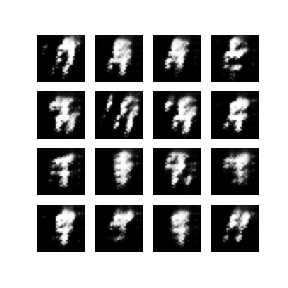

In [ ]:
#INTENT: Embed gif
embed.embed_file(anim_file3)

#Fourth Code Modification

In [ ]:
#INTENT: Create the fourth code modification generator model with changed input shape
#and updated LeakyReLU slopes

def make_generator_model4(): #Function to make generator model
    model = tf.keras.Sequential() #Create model
    model.add(layers.Dense(7*7*512, use_bias=False, input_shape=(256,))) #Add 7, 7, 512 dense layer with no bias
    model.add(layers.BatchNormalization()) #Add Batch Normalization
    model.add(layers.LeakyReLU(0.01)) #LeakyReLU activation method
    model.add(layers.Dropout(0.50)) #Dropout layer randomly sets its input units to 0 at 50% rate

    model.add(layers.Reshape((7, 7, 512))) #Reshape to match dense layer dimensions
    assert model.output_shape == (None, 7, 7, 512)  #Note: None is the batch size

    #Use upsampling layers to produce an image from seed (random noise)
    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False)) #Conv2DTranspose to 256, (5,5)
    #with padding and no bias
    assert model.output_shape == (None, 7, 7, 256) #Output as 7, 7, 256 dimension object
    model.add(layers.BatchNormalization()) #Add Batch Normalization
    model.add(layers.LeakyReLU(0.01)) #LeakyReLU activation method
    model.add(layers.Dropout(0.50)) #Dropout layer randomly sets its input units to 0 at 50% rate

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)) #Conv2DTranspose to 128, (5,5)
    #with padding and no bias
    assert model.output_shape == (None, 7, 7, 128) #Output as 7, 7, 128 dimension object
    model.add(layers.BatchNormalization()) #Add Batch Normalization
    model.add(layers.LeakyReLU(0.01)) #LeakyReLU activation method
    model.add(layers.Dropout(0.50)) #Dropout layer randomly sets its input units to 0 at 50% rate

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)) #Conv2DTranspose to 64, (5,5)
    #with (2,2) strides with padding and no bias
    assert model.output_shape == (None, 14, 14, 64) #Output as 14, 14, 64 dimension object
    model.add(layers.BatchNormalization()) #Add Batch Normalization
    model.add(layers.LeakyReLU(0.01)) #LeakyReLU activation method
    model.add(layers.Dropout(0.50)) #Dropout layer randomly sets its input units to 0 at 50% rate

    #Reach desired image size of 28x28x1
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')) #tanh activation
    #Conv2DTranspose to 1, (5,5) with (2,2) strides and padding and no bias
    assert model.output_shape == (None, 28, 28, 1) #Assert (None, 28, 28, 1) output

    return model #Return model

In [ ]:
#INTENT: Create the fourth code modification discriminator model with updated LeakyReLU slopes

def make_discriminator_model4(): #Function to make discriminator model
    model = tf.keras.Sequential() #Create model
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', #64, (5,5) Conv2D layer with (2,2) strides and padding
                                     input_shape=[28, 28, 1])) #Input shape (28, 28, 1)
    model.add(layers.BatchNormalization()) #Add Batch Normalization                                 
    model.add(layers.LeakyReLU(0.01)) #LeakyReLU activation method
    model.add(layers.Dropout(0.30)) #Dropout layer randomly sets its input units to 0 at 30% rate

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')) #Conv2D 128, (5,5) dimension with (2,2) strides and padding
    model.add(layers.BatchNormalization()) #Add Batch Normalization
    model.add(layers.LeakyReLU(0.01)) #LeakyReLU activation method
    model.add(layers.Dropout(0.30)) #Dropout layer randomly sets its input units to 0 at 30% rate

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same')) #Conv2D 256, (5,5) dimension with (2,2) strides and padding
    model.add(layers.BatchNormalization()) #Add Batch Normalization
    model.add(layers.LeakyReLU(0.01)) #LeakyReLU activation method
    model.add(layers.Dropout(0.30)) #Dropout layer randomly sets its input units to 0 at 30% rate

    model.add(layers.Flatten()) #Flatten the Conv2D layer
    model.add(layers.Dense(1)) #Dense layer as output

    return model #Return model

In [ ]:
#INTENT: With fourth code modification, train new generator and discriminator objects and create image gif 

(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data() #Import training image/label data

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32') #Reshape to 28, 28, 1
train_images = (train_images - 127.5) / 127.5  #Normalize the images to [-1, 1]

BUFFER_SIZE = 60000 #Set constant BUFFER_SIZE
BATCH_SIZE = 64 #Set constant BATCH_SIZE at 64 from 256

#Slice (horizontally), batch, and shuffle the training data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE) #Create random dataset from tensor slices
#With BUFFER_SIZE and BATCH_SIZE

generator = make_generator_model4() #Make generator

discriminator = make_discriminator_model4() #Make discriminator

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True) #Use BinaryCrossentropy

#Generator and discriminator optimizers are different since each network is trained separately
generator_optimizer = tf.keras.optimizers.Adam(1e-4) #Generator optimizer with 'Adam' and very small learning rate
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4) #Discriminator optimizer with 'Adam' and very small learning rate

#Define the training loop
EPOCHS = 50 #Number of epochs to iterate through 
noise_dim = 256 #Dimensions of noise
num_examples_to_generate = 16 #Number of examples to generate
noise = tf.random.normal([1, noise_dim]) #Set noise variable with new noise_dim

seed = tf.random.normal([num_examples_to_generate, noise_dim]) #Set new seed with new noise

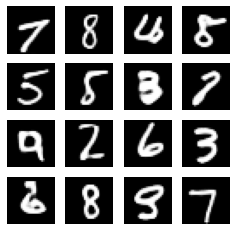

In [ ]:
#INTENT: Train the model

#Train generator and discriminator simultaneously
train(train_dataset, EPOCHS)

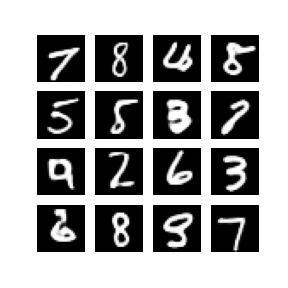

In [ ]:
#INTENT: Display image

display_image(EPOCHS)

In [ ]:
#INTENT: Use imageio to create animated gif using images saved during training
anim_file4 = 'dcgan4.gif'

with imageio.get_writer(anim_file4, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


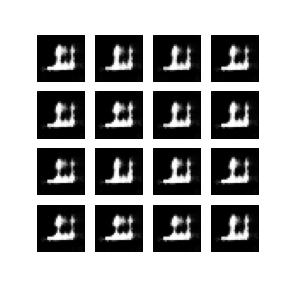

In [ ]:
#INTENT: Embed gif
embed.embed_file(anim_file4)

#Appendix A Code Modification



In [ ]:
#INTENT: With appendix A code modification, train new generator and discriminator objects and create image gif 

(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  #Normalize the images to [-1, 1]

BUFFER_SIZE = 60000
BATCH_SIZE = 256

#Slice (horizontally), batch, and shuffle the training data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

generator = make_generator_model1()

discriminator = make_discriminator_model()

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

#Generator and discriminator optimizers are different since each network is trained separately
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

#Define the training loop
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16


#Keep seed as is

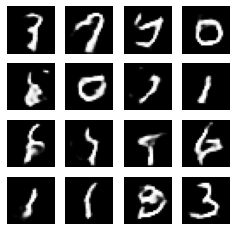

In [ ]:
#INTENT: Train the model

#Train generator and discriminator simultaneously
train(train_dataset, EPOCHS)

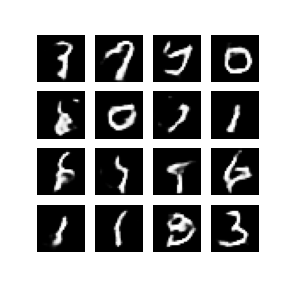

In [ ]:
#INTENT: Display image

display_image(EPOCHS)

In [ ]:
#INTENT: Use imageio to create animated gif using images saved during training
anim_fileA = 'dcganA.gif'

with imageio.get_writer(anim_fileA, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


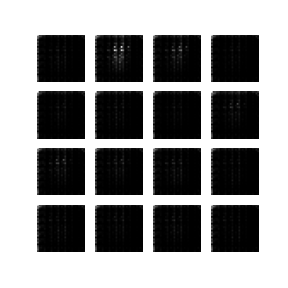

In [ ]:
#INTENT: Embed gif
embed.embed_file(anim_fileA)

#Appendix E Code Modification

In [ ]:
#INTENT: Create the appendix E code modification generator model

def make_generator_modelE(): #Function to make generator model
    model = tf.keras.Sequential() #Create model
    model.add(layers.Dense(7*7*512, use_bias=False, input_shape=(256,))) #Add 7, 7, 512 dense layer with no bias
    model.add(layers.BatchNormalization()) #Add Batch Normalization
    model.add(layers.LeakyReLU(0.01)) #LeakyReLU activation method
    model.add(layers.Dropout(0.50)) #Dropout layer randomly sets its input units to 0 at 50% rate

    model.add(layers.Reshape((7, 7, 512))) #Reshape to match dense layer dimensions
    assert model.output_shape == (None, 7, 7, 512)  #Note: None is the batch size

    #Use upsampling layers to produce an image from seed (random noise)
    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False)) #Conv2DTranspose to 256, (5,5)
    #with padding and no bias
    assert model.output_shape == (None, 7, 7, 256) #Output as 7, 7, 256 dimension object
    model.add(layers.BatchNormalization()) #Add Batch Normalization
    model.add(layers.LeakyReLU(0.01)) #LeakyReLU activation method
    model.add(layers.Dropout(0.50)) #Dropout layer randomly sets its input units to 0 at 50% rate

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)) #Conv2DTranspose to 128, (5,5)
    #with padding and no bias
    assert model.output_shape == (None, 7, 7, 128) #Output as 7, 7, 128 dimension object
    model.add(layers.BatchNormalization()) #Add Batch Normalization
    model.add(layers.LeakyReLU(0.01)) #LeakyReLU activation method
    model.add(layers.Dropout(0.50)) #Dropout layer randomly sets its input units to 0 at 50% rate

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)) #Conv2DTranspose to 64, (5,5)
    #with (2,2) strides with padding and no bias
    assert model.output_shape == (None, 14, 14, 64) #Output as 14, 14, 64 dimension object
    model.add(layers.BatchNormalization()) #Add Batch Normalization
    model.add(layers.LeakyReLU(0.01)) #LeakyReLU activation method
    model.add(layers.Dropout(0.50)) #Dropout layer randomly sets its input units to 0 at 50% rate

    #Reach desired image size of 28x28x1
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')) #tanh activation
    #Conv2DTranspose to 1, (5,5) with (2,2) strides and padding and no bias
    assert model.output_shape == (None, 28, 28, 1) #Assert (None, 28, 28, 1) output

    return model #Return model

In [ ]:
#INTENT: Create the appendix E code modification

def make_discriminator_modelE(): #Function to make discriminator model
    model = tf.keras.Sequential() #Create model
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', #64, (5,5) Conv2D layer with (2,2) strides and padding
                                     input_shape=[28, 28, 1])) #Input shape (28, 28, 1)
    model.add(layers.BatchNormalization()) #Add Batch Normalization                                 
    model.add(layers.LeakyReLU(0.01)) #LeakyReLU activation method
    model.add(layers.Dropout(0.30)) #Dropout layer randomly sets its input units to 0 at 30% rate

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')) #Conv2D 128, (5,5) dimension with (2,2) strides and padding
    model.add(layers.BatchNormalization()) #Add Batch Normalization
    model.add(layers.LeakyReLU(0.01)) #LeakyReLU activation method
    model.add(layers.Dropout(0.30)) #Dropout layer randomly sets its input units to 0 at 30% rate

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same')) #Conv2D 256, (5,5) dimension with (2,2) strides and padding
    model.add(layers.BatchNormalization()) #Add Batch Normalization
    model.add(layers.LeakyReLU(0.01)) #LeakyReLU activation method
    model.add(layers.Dropout(0.30)) #Dropout layer randomly sets its input units to 0 at 30% rate

    model.add(layers.Flatten()) #Flatten the Conv2D layer
    model.add(layers.Dense(1)) #Dense layer as output

    return model #Return model

In [ ]:
#INTENT: With fourth code modification, train new generator and discriminator objects and create image gif 

(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data() #Import training image/label data

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32') #Reshape to 28, 28, 1
train_images = (train_images - 127.5) / 127.5  #Normalize the images to [-1, 1]

BUFFER_SIZE = 60000 #Set constant BUFFER_SIZE
BATCH_SIZE = 64 #Set constant BATCH_SIZE at 64 from 256

#Slice (horizontally), batch, and shuffle the training data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE) #Create random dataset from tensor slices
#With BUFFER_SIZE and BATCH_SIZE

generator = make_generator_modelE() #Make generator

discriminator = make_discriminator_modelE() #Make discriminator

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True) #Use BinaryCrossentropy

#Generator and discriminator optimizers are different since each network is trained separately
generator_optimizer = tf.keras.optimizers.Adam(1e-5) #Generator optimizer with 'Adam' and very small learning rate
discriminator_optimizer = tf.keras.optimizers.Adam(1e-5) #Discriminator optimizer with 'Adam' and very small learning rate

#Define the training loop
EPOCHS = 30 #Number of epochs to iterate through 
noise_dim = 512 #Dimensions of noise
num_examples_to_generate = 16 #Number of examples to generate
noise = tf.random.normal([1, noise_dim]) #Set noise variable with new noise_dim

seed = tf.random.normal([num_examples_to_generate, noise_dim]) #Set new seed with new noise

In [ ]:
#INTENT: Train the model

#Train generator and discriminator simultaneously
train(train_dataset, EPOCHS)

In [ ]:
#INTENT: Display image

display_image(EPOCHS)

In [ ]:
#INTENT: Use imageio to create animated gif using images saved during training
anim_fileE = 'dcganE.gif'

with imageio.get_writer(anim_fileE, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
#INTENT: Embed gif
embed.embed_file(anim_fileE)